In [1]:
# Import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


In [2]:
# Set variable for file_path and data_dir
file_path = r"/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Alzheimers_Image_data/dataset"
data_dir = pathlib.Path(file_path)


In [3]:
# Split train and validation data
SEED = 1234
BATCH_SIZE = 10
IMG_SIZE = (224, 224)  # Adjusted for NASNetLarge input size


In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [5]:
# Print information about the datasets
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(val_data)}")


total train data per batch: 512
total validation data per batch: 128


In [6]:
# Set variable for class_names
class_names = train_data.class_names

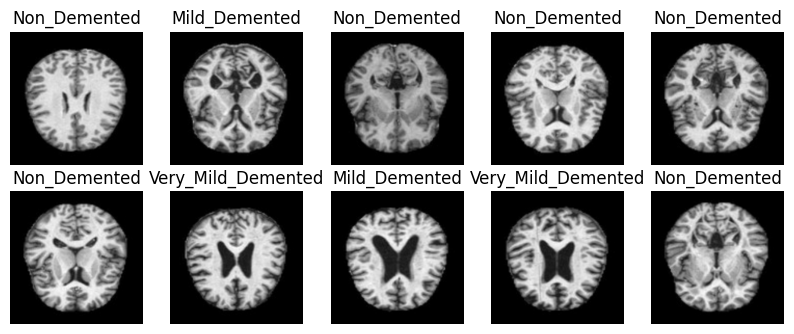

In [7]:
# Plot a sample image from the train_data
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [8]:
# Perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

In [9]:
# Print information about the datasets
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")
print(f"total train data: {len(train_data)}")
print(f"total validation data: {len(val_data)}")
print(f"total test data: {len(test_data)}")

Number of validation batches: 64
Number of test batches: 64
total train data: 512
total validation data: 64
total test data: 64


In [10]:
# Create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE


In [11]:
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [12]:
# Preprocess image input to rescale the image to fit into the pre-trained model
#IMG_SHAPE = IMG_SIZE + (3,)
#base_model = NASNetLarge(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')





# Replace this line with the path to the downloaded NASNetLarge model weights on your local machine
weights_path = '/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Pneumonia_models/NASNet-large-no-top.h5'

# Import the NASNetLarge model
base_model = NASNetLarge(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights=None)

# Load the downloaded weights
base_model.load_weights(weights_path)


In [13]:
# Freeze the entire base_model
base_model.trainable = False

In [14]:
# Set variable for classifier layer
global_average_layer = GlobalAveragePooling2D()

# Set variable for output layer
nClass = len(class_names)
prediction_layer = Dense(nClass, activation='softmax')

In [15]:
# Reconstruct the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [16]:
# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
# Check the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [18]:
# Train the model
initial_epochs = 1
history = model.fit(
    train_data,
    epochs=initial_epochs,
    validation_data=val_data
)

512/512 [==============================] - 569s 1s/step - loss: 1.0144 - accuracy: 0.5154 - val_loss: 0.9259 - val_accuracy: 0.5578


In [19]:
# Perform fine-tuning of the trained model
# Unfreeze the top layers of the base model
base_model.trainable = True

# Set variable for the layer to fine-tune from
fine_tune_at = 10

In [20]:
# Freeze all the layers before "fine_tune_at"
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [21]:
# Compile the model again with a lower learning rate
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=['accuracy']
)


In [22]:
# Check the model summary after fine-tuning
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [23]:
# Resume model training
fine_tune_epochs = 4
total_epochs = initial_epochs + fine_tune_epochs

In [24]:
# Train the model again
history_fine_tune = model.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_data
)


Epoch 1/5


512/512 [==============================] - 2625s 5s/step - loss: 0.8385 - accuracy: 0.6102 - val_loss: 0.7088 - val_accuracy: 0.6547
Epoch 2/5
512/512 [==============================] - 3118s 6s/step - loss: 0.5650 - accuracy: 0.7539 - val_loss: 0.5174 - val_accuracy: 0.7609
Epoch 3/5
512/512 [==============================] - 2822s 6s/step - loss: 0.3103 - accuracy: 0.8713 - val_loss: 0.3628 - val_accuracy: 0.8547
Epoch 4/5
512/512 [==============================] - 3032s 6s/step - loss: 0.1504 - accuracy: 0.9453 - val_loss: 0.3108 - val_accuracy: 0.8750
Epoch 5/5
512/512 [==============================] - 2919s 6s/step - loss: 0.0819 - accuracy: 0.9689 - val_loss: 0.2185 - val_accuracy: 0.9328


In [25]:
# Evaluate the model on test data
print("-----------------------------------After Fine-tuning model-----------------------------------")
model.evaluate(test_data)

-----------------------------------After Fine-tuning model-----------------------------------
64/64 [==============================] - 89s 1s/step - loss: 0.2627 - accuracy: 0.9187


[0.26269686222076416, 0.918749988079071]

In [26]:
# Use test data to make predictions
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

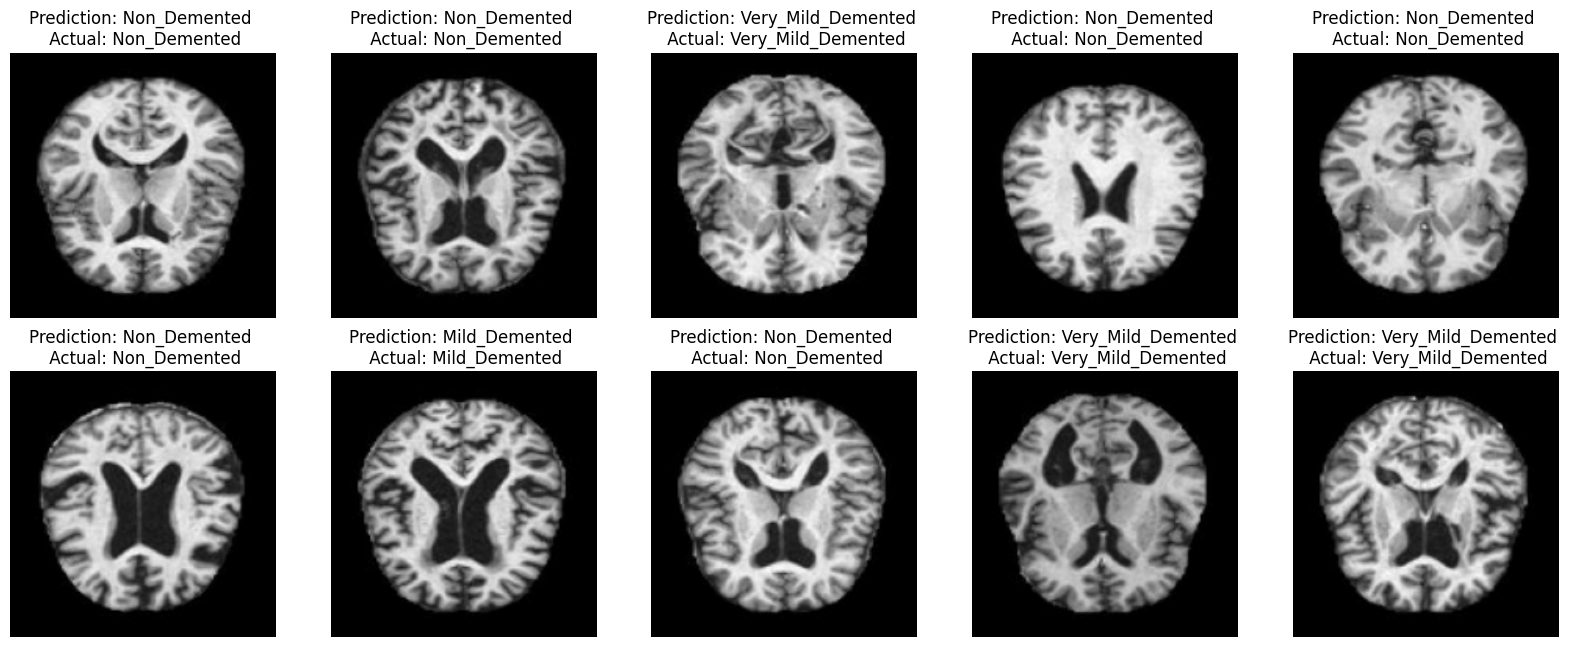

In [27]:
# Plot predictions vs actual labels
plt.figure(figsize=(20, 20))
for i in range(10):
    axs = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
    plt.axis('off')

In [28]:
# Calculate and print the confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd

In [29]:
# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []


In [30]:
# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)

    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

In [31]:
# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

Confusion Matrix:
[[ 79   1   3   9]
 [  1   7   0   0]
 [  0   0 295  23]
 [  2   0  11 209]]
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.86      0.91        92
 Moderate_Demented       0.88      0.88      0.88         8
      Non_Demented       0.95      0.93      0.94       318
Very_Mild_Demented       0.87      0.94      0.90       222

          accuracy                           0.92       640
         macro avg       0.92      0.90      0.91       640
      weighted avg       0.92      0.92      0.92       640



<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x600 with 0 Axes>

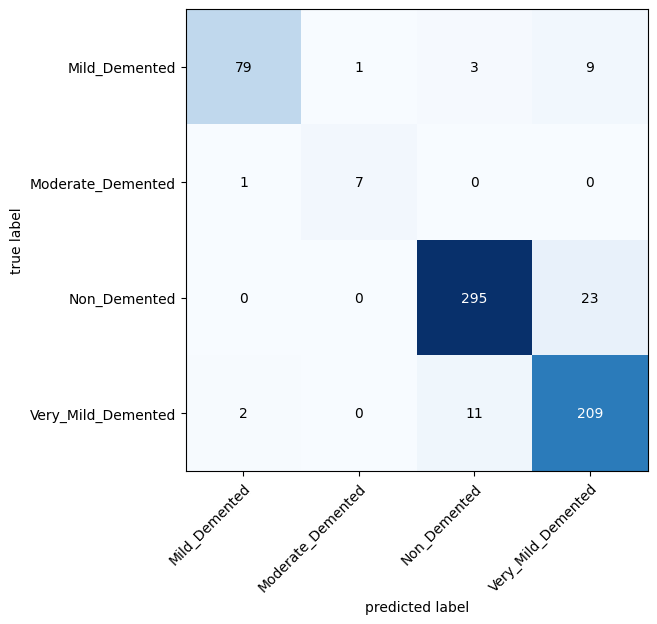

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, figsize=(8, 6), class_names=class_names)
plt.show

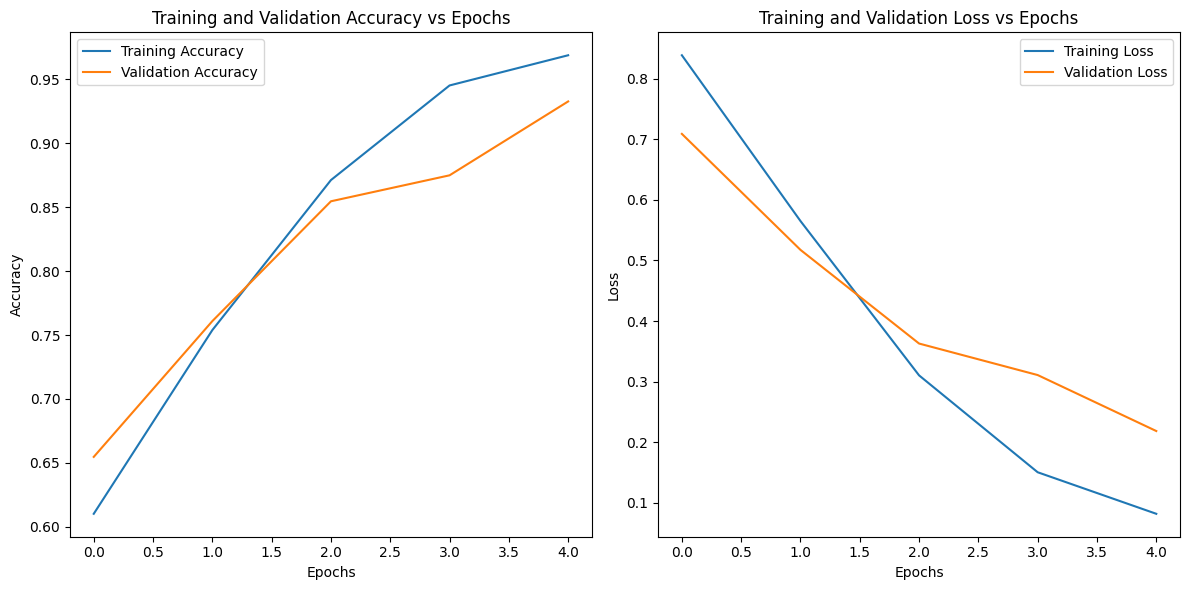

In [33]:
# Get the training history
history_dict = history_fine_tune.history

# Plot training/validation accuracy vs epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training/validation loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()